# Forecasting Traffic Using A3T-GCN


In recent years, the concept of smart cities has become increasingly popular. This idea
refers to cities where data is used to manage and improve operations and services. In this context,
one of the main sources of appeal is the creation of intelligent transportation systems. Accurate traffic
forecasts can help traffic managers to optimize traffic signals, plan infrastructure, and reduce congestion.
However, traffic forecasting is a challenging problem due to complex spatial and temporal dependencies.

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-geometric-temporal==0.54.0

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploring the PeMS-M dataset

The
original dataset was obtained by collecting traffic speed from 39,000 sensor stations on the weekdays
of May and June 2012 using the Caltrans Performance Measurement System (PeMS). We will only
consider 228 stations across District 7 of California in the medium variant. These stations output
30-second speed measurements that are aggregated into 5-minute intervals in this dataset. For example,
the following figure shows the Caltrans PeMS (pems.dot.ca.gov) with various traffic speeds:

![PeMS](./1.png)

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# Kaggle Dataset
# https://www.kaggle.com/datasets/ahmdtolba/pems-m?resource=download&select=PeMSD7_W_228.csv

In [3]:
!conda install -y pandas

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.3

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.3



## Package Plan ##

  environment location: /home/lacie/miniconda3/envs/gcn

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bottleneck-1.3.5           |   py38h7deecbd_0         115 KB
    numexpr-2.8.4              |   py38hc78ab66_1         136 KB
    pytz-2022.7                |   py38h06a4308_0         209 KB
    ------------------------------------------------------------
                                           Total:         460 KB

The following NEW packages will be INSTALLED:

  bottleneck         pkgs/main/linux-64::bottleneck-

In [9]:
!conda install -y cycler kiwisolver

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.3

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.3



## Package Plan ##

  environment location: /home/lacie/miniconda3/envs/gcn

  added / updated specs:
    - cycler
    - kiwisolver


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    kiwisolver-1.4.4           |   py38h6a678d5_0          76 KB
    ------------------------------------------------------------
                                           Total:          76 KB

The following NEW packages will be INSTALLED:

  kiwisolver         pkgs/main/linux-64::kiwisolver-1.4.4-py38h6a678d5_0 



                                                                                
Prepari

In [3]:
import pandas as pd

speeds = pd.read_csv('/home/lacie/Data/PeMSD7/PeMSD7_V_228.csv', names=range(0,228))
distances = pd.read_csv('/home/lacie/Data/PeMSD7/PeMSD7_W_228.csv', names=range(0,228))

The first thing we want to do with this dataset is to visualize the evolution of traffic speed. This is a
classic in time series forecasting since characteristics such as seasonality can be extremely helpful. On
the other hand, non-stationary time series might need further processing before they can be used.

Text(0, 0.5, 'Traffic speed')

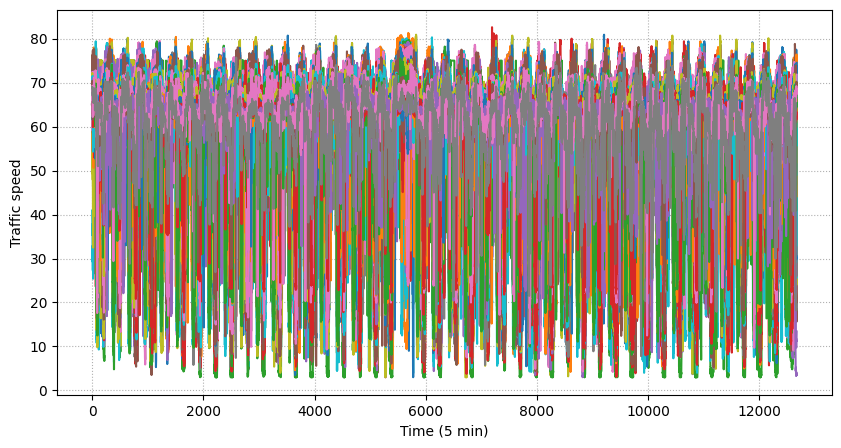

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5), dpi=100) 
plt.plot(speeds) 
plt.grid(linestyle=':') 
plt.xlabel('Time (5 min)') 
plt.ylabel('Traffic speed')  

Text(0, 0.5, 'Traffic speed')

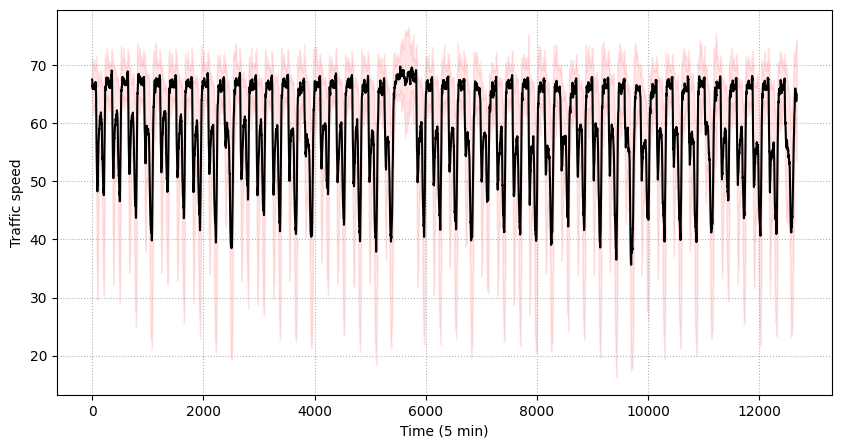

In [5]:
# Plot mean/std traffic speed
mean = speeds.mean(axis=1)
std = speeds.std(axis=1)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(mean, 'k-')
plt.grid(linestyle=':')
plt.fill_between(mean.index, mean-std, mean+std, color='r', alpha=0.1)
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed')

This figure is much more comprehensible. We can see a clear seasonality (pattern) in the time series
data, except around the 5,800 th data sample. The traffic speed has a lot of variability with important
spikes. This is understandable because the sensor stations are spread throughout District 7 of California:
traffic might be jammed for some sensors but not for others.

We can verify that by plotting the correlation between the speed values from every sensor. In addition
to that, we can compare it with the distances between each station. Stations close to each other should
display similar values more often than distant ones.


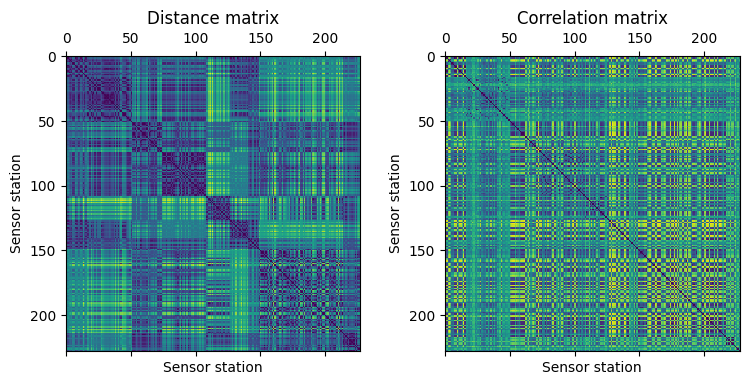

In [6]:
# We can also visualize the correlation between the timeseries in different routes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout(pad=3.0)
ax1.matshow(distances)
ax1.set_xlabel("Sensor station")
ax1.set_ylabel("Sensor station")
ax1.title.set_text("Distance matrix")
ax2.matshow(-np.corrcoef(speeds.T))
ax2.set_xlabel("Sensor station")
ax2.set_ylabel("Sensor station")
ax2.title.set_text("Correlation matrix")

Interestingly, long distances between stations do not mean they are not highly correlated (and vice
versa). This is particularly important if we only consider a subset of this dataset: 
<b> close stations might have very different outputs, making traffic forecasting more difficult. </b>

# Processing the dataset

Now that we have more information about this dataset, it is time to process it before we can feed it
to a T-GNN.

The first step consists of transforming the tabular dataset into a temporal graph. So, first, we need to
create a graph from the raw data. In other words, we must connect the different sensor stations in a
meaningful way. Fortunately, we have access to the distance matrix, which should be a good way to
connect the stations.

There are several options to compute the adjacency matrix from the distance matrix. For example, we
could assign a link when the distance between two stations is inferior to the mean distance. Instead, we
will perform a more advanced processing to calculate a weighted adjacency matrix.
Instead of binary values, we calculate weights between 0 (no connection) and 1 (strong connection)
using the following formula:

![img](./2.png)

In [8]:
def compute_adj(distances, sigma2=0.1, epsilon=0.5):
    d = distances.to_numpy() / 10000.
    d2 = d * d
    n = distances.shape[0]  
    w_mask = np.ones([n, n]) - np.identity(n)
    return np.exp(-d2 / sigma2) * (np.exp(-d2 / sigma2) >= epsilon) * w_mask

adj = compute_adj(distances)

Text(0, 0.5, 'Sensor station')

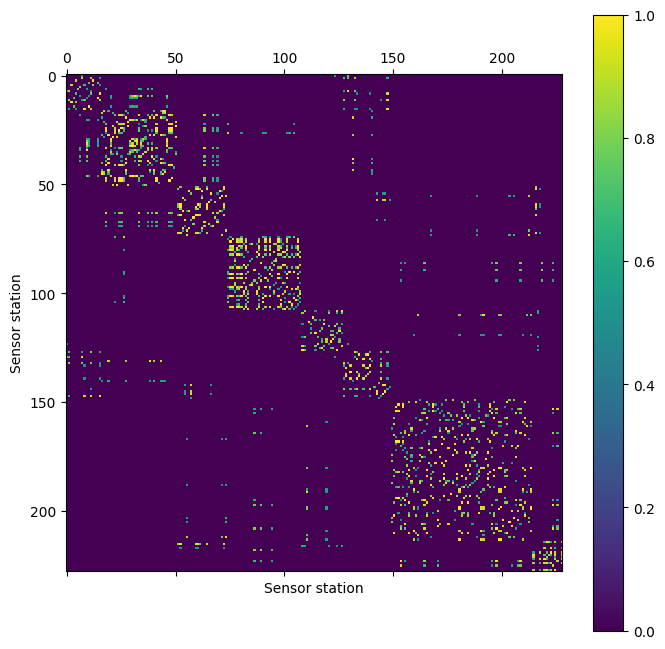

In [9]:
plt.figure(figsize=(8, 8))
cax = plt.matshow(adj, False)
plt.colorbar(cax)
plt.xlabel("Sensor station")
plt.ylabel("Sensor station")

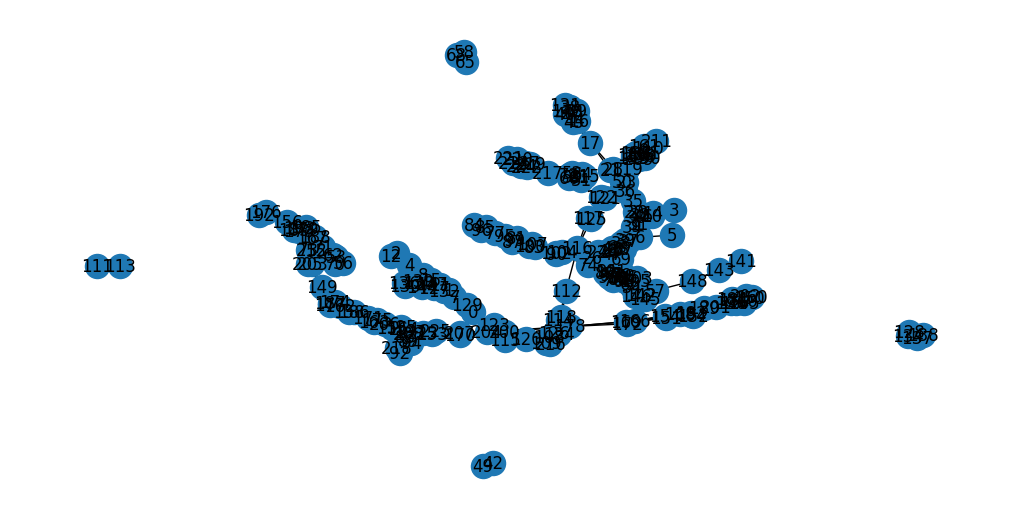

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(adj):
    plt.figure(figsize=(10,5))
    rows, cols = np.where(adj > 0)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw(G, with_labels=True)
    plt.show()

plot_graph(adj)

Indeed, many nodes are interconnected because they are very close to each other. Yet, despite that,
we can distinguish several branches that could correspond to actual roads.

Now that we have a graph, we can focus on the time series aspect of this problem. The first step consists
of normalizing the speed values so they can be fed to a neural network. In the traffic forecasting literature,
many authors choose a z-score normalization (or standardization)

In [11]:
# Apply z-score
def zscore(x, mean, std):
    return (x - mean) / std

speeds_norm = zscore(speeds, speeds.mean(axis=0), speeds.std(axis=0))

# Create dataset
lags = 24
horizon = 48
xs = []
ys = []
for i in range(lags, speeds_norm.shape[0]-horizon):
    xs.append(speeds_norm.to_numpy()[i-lags:i].T)
    ys.append(speeds_norm.to_numpy()[i+horizon-1])

# Convert adjacency matrix to edge_index (COO format)
edge_index = (np.array(adj) > 0).nonzero()
edge_index

(array([  0,   0,   0, ..., 227, 227, 227]),
 array([  7, 123, 129, ..., 221, 222, 224]))

In [12]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

dataset = StaticGraphTemporalSignal(edge_index, adj[adj > 0], xs, ys)
dataset[0]

/home/lacie/miniconda3/envs/gcn/lib/python3.8/site-packages/torch_geometric_temporal/signal/static_graph_temporal_signal.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.LongTensor(self.edge_index)


Data(x=[228, 24], edge_index=[2, 1664], edge_attr=[1664], y=[228])

In [13]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# Implementing the A3T-GCN architecture

In this section, we will train an Attention Temporal Graph Convolutional Network (A3T-GCN), designed
for traffic forecasting. This architecture allows us to consider complex spatial and temporal dependencies:

• Spatial dependencies refer to the fact that the traffic condition of a location can be influenced by the
traffic condition of nearby locations. For example, traffic jams often spread to neighboring roads.

• Temporal dependencies refer to the fact that the traffic condition of a location at a time can be
influenced by the traffic condition of the same location at previous times. For example, if a road
is congested during the morning peak, it is likely to remain congested until the evening peak.

A3T-GCN is an improvement over the temporal GCN (TGCN) architecture. The TGCN is a combination
of a GCN and GRU that produces hidden vectors from each input time series. The combination of these
two layers captures spatial and temporal information from the input. An attention model is then used
to calculate weights and output a context vector. The final prediction is based on the resulting context
vector. The addition of this attention model is motivated by the need to understand global trends.

![img](./3.png)

In [15]:
import torch
from torch_geometric_temporal.nn.recurrent import A3TGCN


class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, periods):
        super().__init__()
        self.tgnn = A3TGCN(in_channels=dim_in, out_channels=32, periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_attr):
        h = self.tgnn(x, edge_index, edge_attr).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(lags, 1).to('gpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
model.train()
print(model)

# Training
for epoch in range(30):
    loss = 0
    step = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_attr)
        loss += torch.mean((y_pred-snapshot.y)**2)
        step += 1
    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 5 == 0:
        print(f"Epoch {epoch:>2} | Train MSE: {loss:.4f}")

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(24, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(24, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(24, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)
Epoch  0 | Train MSE: 1.0184
Epoch  5 | Train MSE: 0.9730
Epoch 10 | Train MSE: 0.9559
Epoch 15 | Train MSE: 0.9408
Epoch 20 | Train MSE: 0.9253
Epoch 25 | Train MSE: 0.9120


Now that our model is trained, we have to evaluate it. Beyond classic metrics such as <b> Root Mean
Squared Error (RMSE) </b> and <b> Mean Absolute Error (MAE) </b>, it is particularly helpful to compare our
model to a baseline solution with time series data. In the following list, we will introduce two methods:

• Using <b> Random Walk (RW) </b> as a naïve forecaster. In this case, RW refers to using the last
observation as the predicted value. In other words, the value at is the same one as at + ℎ .

• Using <b> Historical Average (HA) </b> as a slightly more evolved solution. In this case, we calculate
the mean traffic speed of previous samples as the value at + ℎ . In this example, we wi

In [16]:
def inverse_zscore(x, mean, std):
    return x * std + mean

y_test = []
for snapshot in test_dataset:
    y_hat = snapshot.y.numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    y_test = np.append(y_test, y_hat)

gnn_pred = []
model.eval()
for snapshot in test_dataset:
    snapshot = snapshot
    y_hat = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_weight).squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    gnn_pred = np.append(gnn_pred, y_hat)

In [17]:
def MAE(real, pred):
    return np.mean(np.abs(pred - real))

def RMSE(real, pred):
    return np.sqrt(np.mean((pred - real) ** 2))

def MAPE(real, pred):
    return np.mean(np.abs(pred - real) / (real + 1e-5))

print(f'GNN MAE  = {MAE(gnn_pred, y_test):.4f}')
print(f'GNN RMSE = {RMSE(gnn_pred, y_test):.4f}')
print(f'GNN MAPE = {MAPE(gnn_pred, y_test):.4f}')

GNN MAE  = 8.3710
GNN RMSE = 12.0484
GNN MAPE = 0.1496


In [18]:
rw_pred = []
for snapshot in test_dataset:
    y_hat = snapshot.x[:,-1].squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    rw_pred = np.append(rw_pred, y_hat)

print(f'RW MAE  = {MAE(rw_pred, y_test):.4f}')
print(f'RW RMSE = {RMSE(rw_pred, y_test):.4f}')
print(f'RW MAPE = {MAPE(rw_pred, y_test):.4f}')

RW MAE  = 11.0469
RW RMSE = 17.6501
RW MAPE = 0.2999


In [19]:
ha_pred = []
for i in range(lags, speeds_norm.shape[0]-horizon):
    y_hat = speeds_norm.to_numpy()[:i].T.mean(axis=1)
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0)) 
    ha_pred.append(y_hat)
ha_pred = np.array(ha_pred).flatten()[-len(y_test):]

print(f'HA MAE  = {MAE(ha_pred, y_test):.4f}')
print(f'HA RMSE = {RMSE(ha_pred, y_test):.4f}')
print(f'HA MAPE = {MAPE(ha_pred, y_test):.4f}')

HA MAE  = 9.3374
HA RMSE = 13.1518
HA MAPE = 0.1633


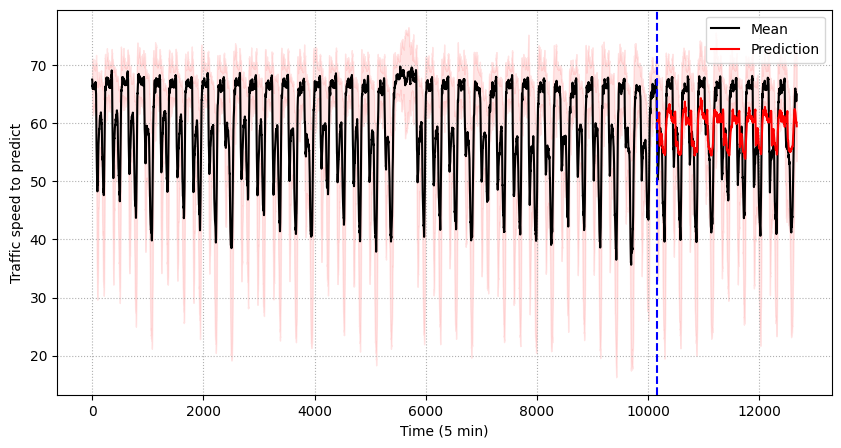

In [20]:
y_preds = [inverse_zscore(model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_weight).squeeze().detach().numpy(), speeds.mean(axis=0), speeds.std(axis=0)).mean() for snapshot in test_dataset]

mean = speeds.mean(axis=1)
std = speeds.std(axis=1)

plt.figure(figsize=(10,5))
plt.plot(np.array(mean), 'k-', label='Mean')
plt.plot(range(len(speeds)-len(y_preds), len(speeds)), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(mean.index, mean-std, mean+std, color='r', alpha=0.1)
plt.axvline(x=len(speeds)-len(y_preds), color='b', linestyle='--')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed to predict')
plt.legend(loc='upper right')